In [26]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import transforms
import numpy as np
import imageio
from moviepy.editor import VideoFileClip
from IPython.display import HTML

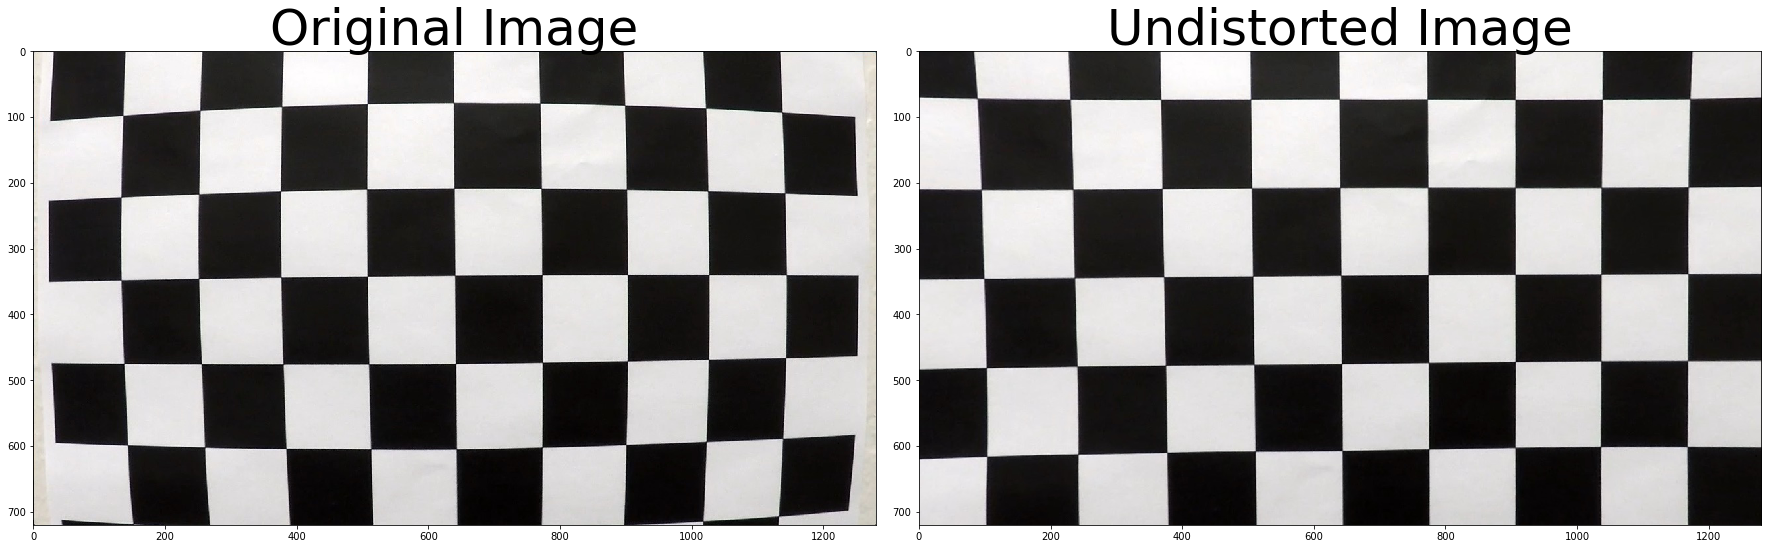

In [27]:
def show_und(img, undistorted):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=50)
    ax2.imshow(undistorted)
    ax2.set_title('Undistorted Image', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.) 

%matplotlib inline
obj_points, img_points = transforms.read_points(rewrite=False, show=False)
# Show train result
img = cv2.imread('./camera_cal/calibration1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
undistorted = transforms.cal_undistort(img, obj_points, img_points)
show_und(img, undistorted)
# Show test result
img = cv2.imread('./test_images/test5.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
undistorted = transforms.cal_undistort(img, obj_points, img_points)
show_und(img, undistorted)

In [28]:
img = undistorted

w = img.shape[1]
h = img.shape[0]

src_img = img.copy()
dst_img = img.copy()

corners = np.float32([[253, 697], [585, 456], [700, 456], [1061, 690]])
new_top_left = np.array([corners[0, 0], 0])
new_top_right = np.array([corners[3, 0], 0])
offset = [50, 0]
src = np.float32([corners[0], corners[1], corners[2], corners[3]])
dst = np.float32([corners[0] + offset, new_top_left + offset, new_top_right - offset, corners[3] - offset])
cv2.polylines(src_img, np.int32([src]), True, (0, 0, 122), thickness=5)
cv2.polylines(dst_img, np.int32([dst]), True, (255, 255, 0), thickness=5)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(src_img)
ax1.set_title('Src points', fontsize=50)
ax2.imshow(dst_img)
ax2.set_title('Dst Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [29]:
tr_img, t_m, inv_m = transforms.perspective_tr(img, src, dst, (img.shape[1], img.shape[0]))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original img', fontsize=50)
ax2.imshow(tr_img)
ax2.set_title('Birdview Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

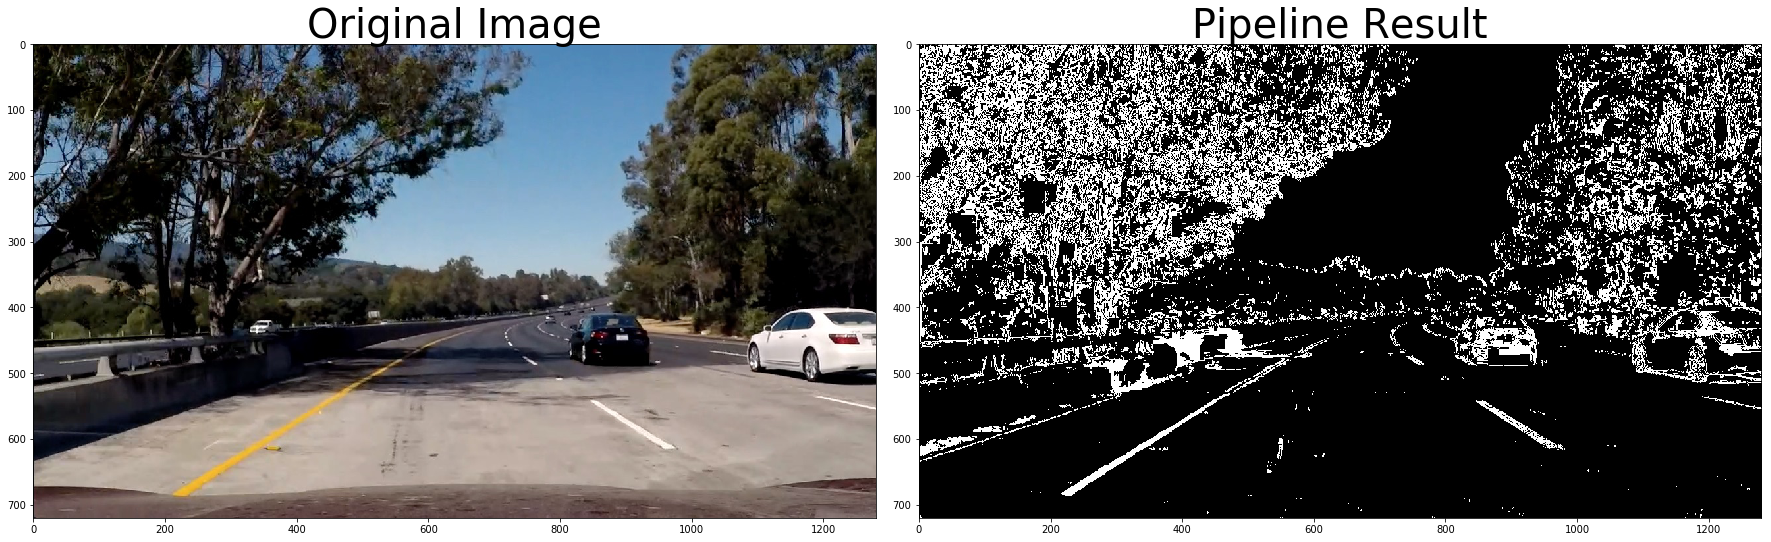

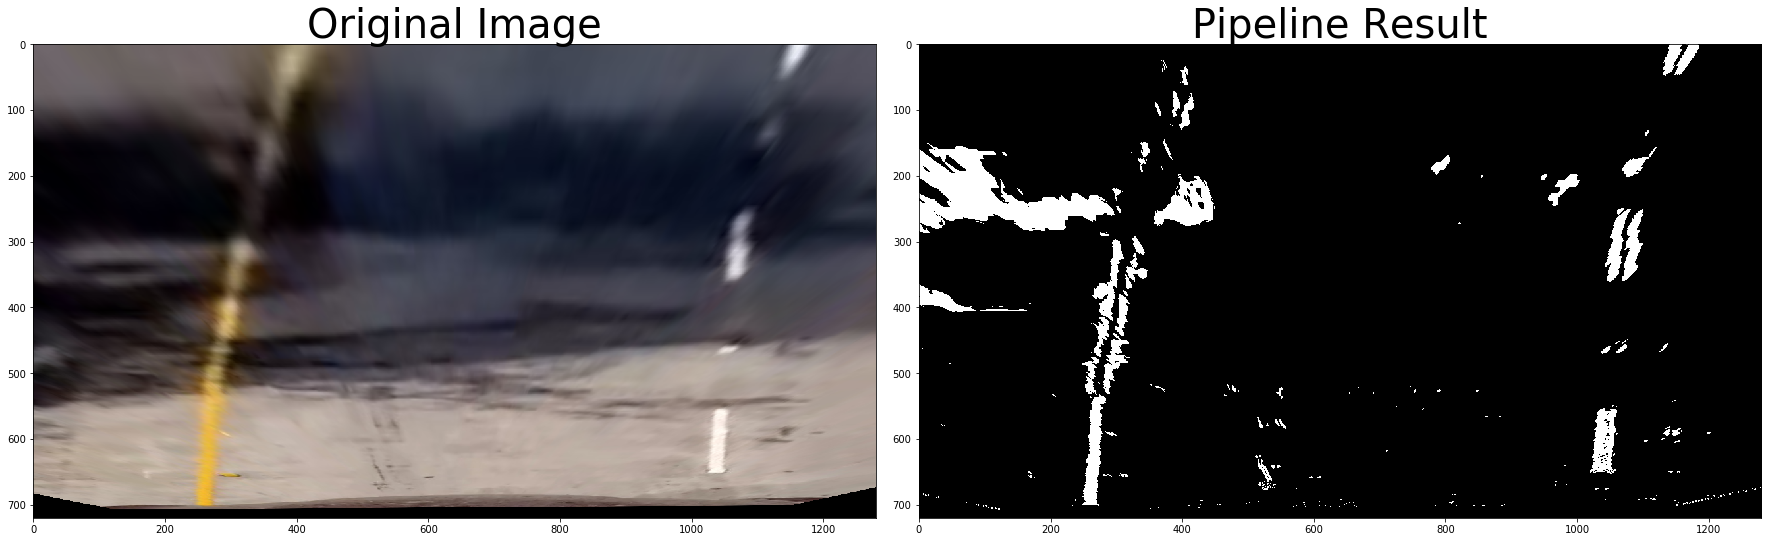

In [70]:
result = transforms.gradient(img)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(img)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(result, cmap='gray')
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

result = transforms.gradient(tr_img)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(tr_img)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(result, cmap='gray')
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

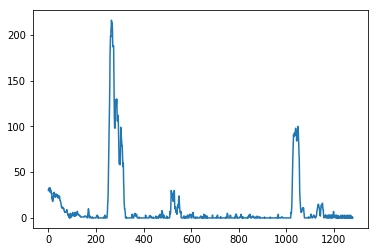

In [31]:
histogram = np.sum(result[img.shape[0]//2:,:], axis=0)
plt.plot(histogram)

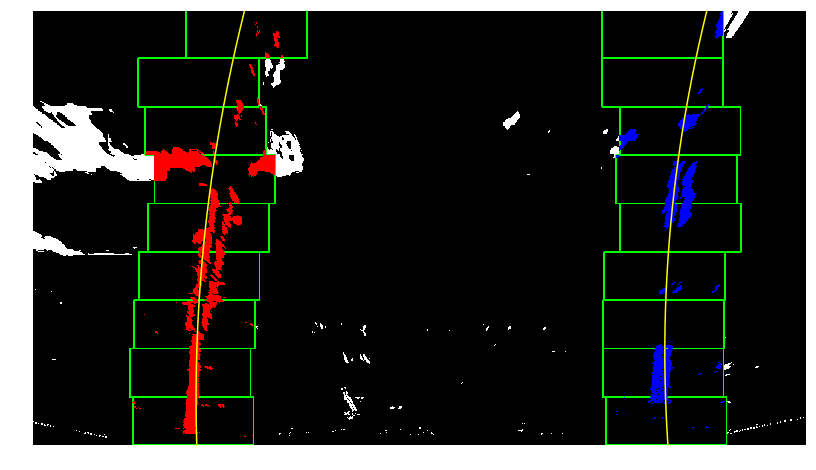

In [81]:
left_fitx, right_fitx, ploty, left_fit, right_fit, out_img = find_lane_lines(binary_warped, debug=True)

plt.figure(figsize=(16,8))
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.axis("off");

In [33]:
def lane_lines2(binary_warped, left_fit, right_fit):
    # Assume you now have a new warped binary image
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0] * (nonzeroy ** 2) + left_fit[1] * nonzeroy +
                                   left_fit[2] - margin)) & (nonzerox < (left_fit[0] * (nonzeroy ** 2) +
                                                                         left_fit[1] * nonzeroy + left_fit[
                                                                             2] + margin)))

    right_lane_inds = ((nonzerox > (right_fit[0] * (nonzeroy ** 2) + right_fit[1] * nonzeroy +
                                    right_fit[2] - margin)) & (nonzerox < (right_fit[0] * (nonzeroy ** 2) +
                                                                           right_fit[1] * nonzeroy + right_fit[
                                                                               2] + margin)))

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0] - 1, binary_warped.shape[0])
    left_fitx = left_fit[0] * ploty ** 2 + left_fit[1] * ploty + left_fit[2]
    right_fitx = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]
    return left_fitx, right_fitx, ploty, left_fit, right_fit

left_fitx, right_fitx, ploty, left_fit, right_fit = lane_lines2(binary_warped, left_fit, right_fit)


(720, 0)

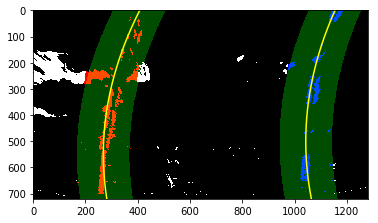

In [34]:
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

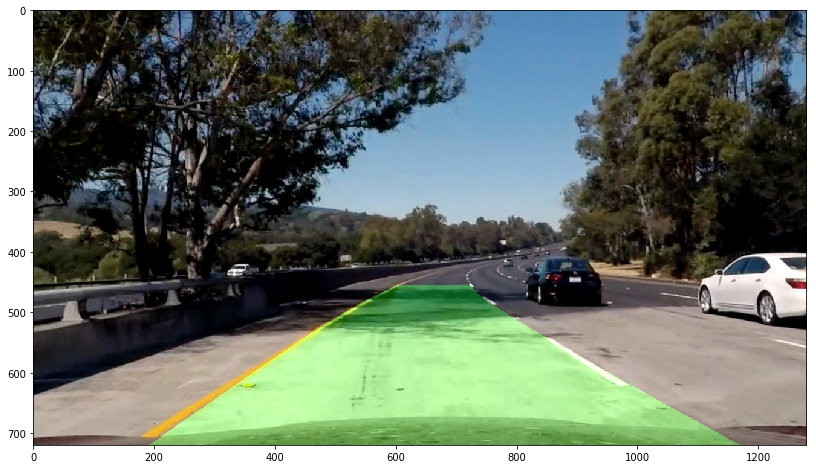

In [35]:
result = transforms.draw(binary_warped, img, inv_m, left_fitx, right_fitx, ploty)
plt.figure(figsize=(16,8))
plt.imshow(result)

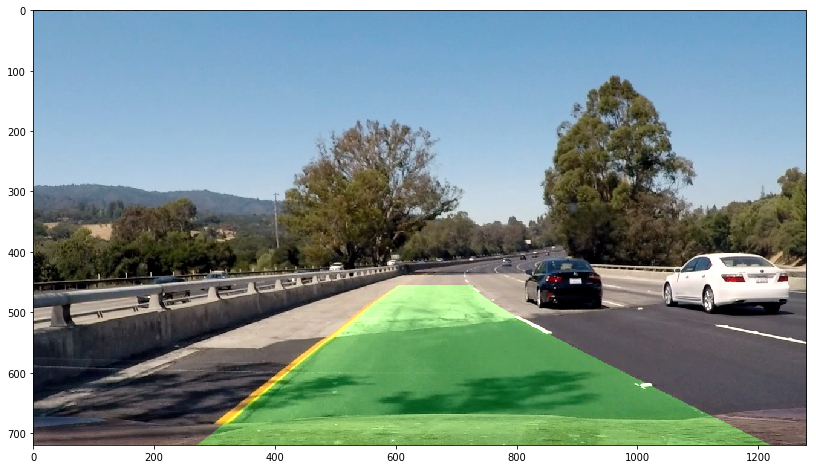

In [36]:
img = cv2.imread('./test_images/test4.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
result = transforms.pipeline(img)
plt.figure(figsize=(16,8))
plt.imshow(result)

In [63]:
left_fit = [] 
right_fit = []
first = False
def pipeline(img):
    global first
    global left_fit
    global right_fit
    obj_points, img_points = transforms.read_points()
    undist = transforms.cal_undistort(img, obj_points, img_points)
    corners = np.float32([[253, 697], [585, 456], [700, 456], [1061, 690]])
    new_top_left = np.array([corners[0, 0], 0])
    new_top_right = np.array([corners[3, 0], 0])
    offset = [50, 0]
    src = np.float32([corners[0], corners[1], corners[2], corners[3]])
    dst = np.float32([corners[0] + offset, new_top_left + offset, new_top_right - offset, corners[3] - offset])
    tr_img, t_m, inv_m = transforms.perspective_tr(undist, src, dst, (undist.shape[1], undist.shape[0]))
    binary_warped = transforms.gradient(tr_img)
    if first:
        left_fitx, right_fitx, ploty, left_fit, right_fit = transforms.lane_lines(binary_warped, visualise=False)
        first = False
    else:
        left_fitx, right_fitx, ploty, left_fit, right_fit = lane_lines2(binary_warped, left_fit, right_fit)
    result = transforms.draw(binary_warped, img, inv_m, left_fitx, right_fitx, ploty)
    return result

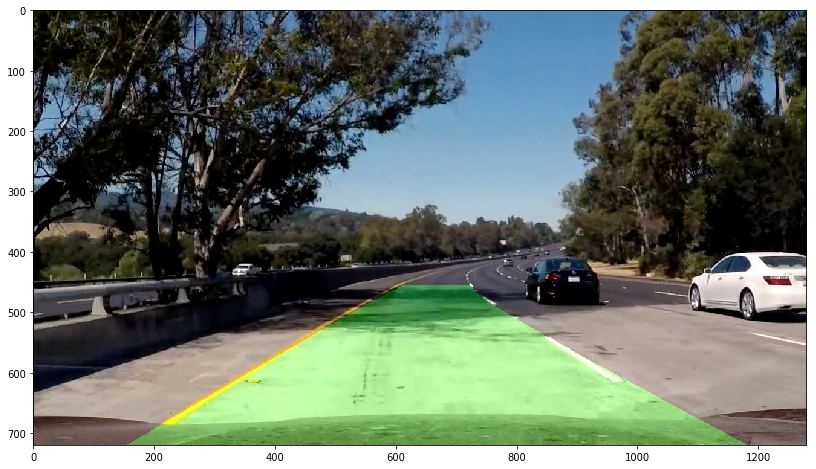

In [67]:
img = cv2.imread('./test_images/test5.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
first = False
result = pipeline(img)
plt.figure(figsize=(16,8))
plt.imshow(result)

In [65]:
video_output = "output_images/project_video_output.mp4"
clip1 = VideoFileClip("project_video.mp4")
left_fit = [] 
right_fit = []
first = True
clip1_output = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time clip1_output.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video output_images/project_video_output.mp4
[MoviePy] Writing video output_images/project_video_output.mp4



 12%|█▏        | 152/1261 [01:43<12:55,  1.43it/s]


 24%|██▍       | 303/1261 [03:24<10:30,  1.52it/s]


 36%|███▌      | 454/1261 [05:04<08:49,  1.52it/s]


 48%|████▊     | 605/1261 [06:43<06:59,  1.56it/s]


 60%|█████▉    | 756/1261 [08:22<05:40,  1.48it/s]


 72%|███████▏  | 906/1261 [40:29<04:07,  1.43it/s]


 84%|████████▎ | 1056/1261 [42:19<02:37,  1.30it/s]


 95%|█████████▌| 1204/1261 [44:07<00:41,  1.38it/s]


100%|█████████▉| 1260/1261 [44:48<00:00,  1.41it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/project_video_output.mp4 

CPU times: user 13min 58s, sys: 54.1 s, total: 14min 52s
Wall time: 44min 49s


In [66]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))

In [68]:
video_challenge_output = "output_images/project_video_challenge_output.mp4"
clip1 = VideoFileClip("challenge_video.mp4")
left_fit = [] 
right_fit = []
first = True
clip1_output = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time clip1_output.write_videofile(video_challenge_output, audio=False)

[MoviePy] >>>> Building video output_images/project_video_challenge_output.mp4
[MoviePy] Writing video output_images/project_video_challenge_output.mp4



 32%|███▏      | 155/485 [01:54<04:14,  1.30it/s]


 64%|██████▎   | 309/485 [03:40<02:07,  1.38it/s]


 95%|█████████▌| 463/485 [05:27<00:15,  1.44it/s]


100%|██████████| 485/485 [05:43<00:00,  1.34it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/project_video_challenge_output.mp4 

CPU times: user 5min 30s, sys: 18.3 s, total: 5min 48s
Wall time: 5min 43s


In [74]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))